<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/nearest_neighbour_analysis_2d_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.special import erf
from sklearn.cluster import DBSCAN
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import cm

import copy
import time
import glob
import os
import gc

In [2]:
# @title Simulations (functions)

def grf_2d(mean, std_dev, pixel, amplitude, k_power):
    # Generate white noise in-place
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel))

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = np.fft.fft2(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel) * pixel
    ky = np.fft.fftfreq(pixel) * pixel

    # Generating FFT momentum 2D array
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    del kx, ky
    gc.collect()

    # Norm of k
    k_norm = np.sqrt(kx_grid**2 + ky_grid**2)
    k_norm[0, 0] = np.inf  # Regularize divergence at k=0
    del kx_grid, ky_grid
    gc.collect()

    # Power Spectrum P_k
    power_spectrum = amplitude * (((2 * np.pi / pixel) * k_norm) ** (-k_power))
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = np.sqrt(power_spectrum, out=power_spectrum) * fft_white_noise
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifft2(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field


def gaussian_to_exp(x, lam):
    mu = np.mean(x)
    sigma = np.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (np.sqrt(2) * sigma)))
    return -1/lam  * np.log(1 - xu)


In [3]:
# @title Clustering (functions)




def DBSCAN_CLUSTERING(data, eps, min_samples):

    """
    INPUTS:
    - data : Array containing the positions of the threshold exceeding events
    - eps : The maximum distance between two samples for one to be considered
    as in the neighborhood of the other.
    - min_samples : The number of samples (or total weight) in a neighborhood
    for a point to be considered as a core point. This includes the point itself.

    OUTPUTS:
    - labels : labels obtained from DBSCAN clustering algorithm
    - clt_pos_dict[ii][jj] : dictionary of threshold exceeding events,
    i : integer from [0, n-1], n is the total number of cluster
    j : integer from [0, m-1], m is the total number of threshold exceeding events
    within the i-th cluster
    """

    """
    Clustering algorithm: DBSCAN
    https://cdn.aaai.org/KDD/1996/KDD96-037.pdf
    """


    # Run DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data)

    # Export labels of clustering analysis
    labels = clustering.labels_
    print("\n Cluster they belong to: ", labels)

    # Initialize empty dictionary
    clt_pos_dict = {}

    # Iterate over all clustes
    for ii in set(labels):

        # Find the index of the cluster
        clt_idx = np.where(labels == ii)
        # Find the coordinates of the cluster using the index
        clt_pos = data[clt_idx]
        # Append the coordinates into the dictionary
        clt_pos_dict[ii] = clt_pos

    return labels, clt_pos_dict


In [4]:
# @title Mass conversion (functions)



def filtering(x,y,pixel):
    """
    Mask for filtering out pixels outside the simulation box.
    """
    domain_mask = (x >= 0) & (x < pixel) & (y >= 0) & (y < pixel)
    return x[domain_mask], y[domain_mask]


def M(c2, c1, threshold):

    """
    First input : above-threshold overdensity
    Second input : above-threshold overdensity



    Define
    M[delta2, delta1]:=0.0311926 (4.25699 + delta1)^4.59551 delta2^4.12181
    If[delta1 <= 0.599,
    HeavisideTheta[delta2 - 0.002/(delta1 - 0.6) - 0.6], 1]

    delta2 (c2) is the amplitude of the above-threshold overdensity,
    delta1 (c1) is the amplitude of an overdensity in one of the
    nearest-neighbouring patches.

    For each nearest-neighbouring patch add deltaM to the mass
    of the "bare" above-threshold patch, M[0,delta2],
    to get the total mass in units of the horizon mass.

    """


    """
    linearly re-scale the amplitudes delta1 and delta2 such that
    0.6 corresponds to the utilised threshold value (at a given rareness).
    """

    c1 = 0.6 * c1 / threshold
    c2 = 0.6 * c2 / threshold


    if c1 <= 0.599:
        return 0.0311926 * (4.25699 + c1)**4.59551 *  c2**4.12181 * np.heaviside(c2 - 0.002/(c1-0.6) - 0.6, 0)

    else:
        return 0.0311926 * (4.25699 + c1)**4.59551 *  c2**4.12181


def dM(c2, c1, threshold):

    """
    Approximate mass increase for each nearest-neighbouring overdensity.
    (Through the "If" command, I have set it equal to zero whenever the
    threshold is not met.)

    deltaM[delta1,delta2]:=If[M[0, delta2] == 0, 0, M[delta1, delta2]-M[0, delta2]]
    """

    mass = M(c2,c1,threshold)

    if mass == 0:
        return 0
    else:
        return mass - M(c2,0,threshold)

def nn_sum(dM_list, d2_ij, threshold):
    """
    Total mass for a given threshold exceedence in a given cluster
    Sum over [k] and the threshold exceedenece
    """
    return np.sum(dM_list) + M(d2_ij, 0, threshold)
# print("neighborhood = ", np.sum(dM_ijk) , "bare =",  M(d2_ij, 0, threshold))





def mass_conversion(exprf, labels, threshold, clt_pos_dict_merged, coordinates_nn):

    """
    Inputs:
    - exprf : exponential random field
    - labels : labels obtained from DBSCAN clustering algorithm
    - threshold: threshold for defining rare events
    - clt_pos_dict_merged[ii][jj]: dictionary of merged threshold exceeding events
    i : integer from [0, n-1], n is the total number of cluster excluding anomoly
    j : integer from [0, m-1], m is the total number of threshold exceeding events
    within the i-th cluster
    - coordinates_nn[ii][coor] : dictionary of merged nearest neighbours of the threshold exceeding events
    i : integer from [0, n-1], n is the total number of cluster excluding anomoly
    coor : coordaintes of the threshold exceeding events with the format '[x, y]'

    Outputs:
    - cluster_mass_i : total mass for a given threshold exceedence in a given cluster
    - bare_mass_i : bare mass for a given threshold exceedence in a given cluster
    """

    """
    Define indices and variables:

    i = Cluster
    j = Threshold Exceedence
    k = Nearest Neighbours


    d2 = delta2 = Threshold exceedence amplitude
    d1 = delta1 = Nearest neighbour amplitude
    """

    # Intialize empty list - vector
    cluster_mass_i = {}

    # Initialize empty dictionary - rank 2 tensor
    # Total mass for all threshold exceedence [j] in each clsuter [i]
    cluster_mass_list_ij = {}

    # for ii in set(labels) -{-1, 1, 2,3,4}:
    for ii in set(labels) -{-1}:
        #Intiialize empty list for each cluster for storing m_ijk
        cluster_mass_list_ij[ii] = []
        #Intiialize empty list for each cluster M_ij
        cluster_mass_i[ii]= []

        for jj in range( len(clt_pos_dict_merged[ii]) ):
            ## position of the j-th threshold exceedence within the j-th cluster - rank 2 tensor
            pos_jj = clt_pos_dict_merged[ii][jj]
            ## amplitude of the j-th threshold exceedence within the i-th cluster - rank 2 tensor
            d2_ij = exprf[pos_jj[0], pos_jj[1] ]

            # Coorindates (x) of the merged neighborhood
            x_ijk = coordinates_nn[ii][f'{pos_jj}'][:,0]
            # Coorindates (y) of the merged neighborhood
            y_ijk = coordinates_nn[ii][f'{pos_jj}'][:,1]

            # If the threshoold is at the edge of the entire simulation, discard
            # neighborhoods that are outside the simulation.
            if (pos_jj[0] == 0 or pos_jj[1]== 0 or pos_jj[0] == pixel -1 or pos_jj[1] == pixel -1 ):
                x_ijk, y_ijk = filtering(x_ijk, y_ijk, pixel)

            # List of amplitudes of the merged neighborhood
            d1_ijk = exprf[x_ijk, y_ijk]

            print(pos_jj, np.round(d2_ij,1), d1_ijk.shape)
            # Initialize empty list - rank 3 tensor
            # delta M, additional mass due to nearest neighbour

            """
            Define
            M[delta2, delta1]:=0.0311926 (4.25699 + delta1)^4.59551 delta2^4.12181
            If[delta1 <= 0.599,
            HeavisideTheta[delta2 - 0.002/(delta1 - 0.6) - 0.6], 1]

            delta2 (d2) is the amplitude of the above-threshold overdensity,
            delta1 (d1) is the amplitude of an overdensity in one of the
            nearest-neighbouring patches.
            """

            dM_ijk = []
            # Calculate additional mass for each nearest neighbour
            for d1 in d1_ijk:
                dM_ijk.append( dM(d1, d2_ij, threshold) )
                # print("Amplitude =", d1, "Neighbor =", dM(d1, d2_ij, threshold) )

            # Total mass for a given threshold exceedence in a given cluster
            cluster_mass_list_ij[ii].append(nn_sum(dM_ijk, d2_ij, threshold))

        cluster_mass_i[ii] = np.sum(cluster_mass_list_ij[ii])
        print(f"Cluster{ii}: total mass list", cluster_mass_list_ij[ii])
        print(f"Cluster{ii}: total mass", cluster_mass_i[ii] )

    return cluster_mass_i, cluster_mass_list_ij


def bare_mass_conversion(exprf, labels, threshold, clt_pos_dict):

    """
    Inputs:
    - exprf : exponential random field
    - labels : labels obtained from DBSCAN clustering algorithm
    - threshold: threshold for defining rare events

    Outputs:
    - bare_mass_i : bare mass for a given threshold exceedence in a given cluster
    """

    """
    Define indices and variables:

    i = Cluster
    j = Threshold Exceedence


    d2 = delta2 = Threshold exceedence amplitude
    d1 = delta1 = Nearest neighbour amplitude != 0
    """

    # Intialize empty list - vector
    bare_mass_i = {}

    # Initialize empty dictionary - rank 2 tensor
    # Total mass for all threshold exceedence [j] in each clsuter [i]
    bare_mass_list_ij = {}

    # for ii in set(labels) -{-1, 1, 2,3,4}:
    for ii in set(labels) -{-1}:
        #Intiialize empty list for each cluster for storing m_ijk
        bare_mass_list_ij[ii] = []
        #Intiialize empty list for each cluster M_ij
        bare_mass_i[ii] = []

        for jj in range( len(clt_pos_dict[ii]) ):
            ## position of the j-th threshold exceedence within the j-th cluster - rank 2 tensor
            pos_jj = clt_pos_dict[ii][jj]
            ## amplitude of the j-th threshold exceedence within the i-th cluster - rank 2 tensor
            d2_ij = exprf[pos_jj[0], pos_jj[1] ]

            print(pos_jj, np.round(d2_ij,1))

            """
            Define
            M[delta2, delta1]:=0.0311926 (4.25699 + delta1)^4.59551 delta2^4.12181
            If[delta1 <= 0.599,
            HeavisideTheta[delta2 - 0.002/(delta1 - 0.6) - 0.6], 1]

            delta2 (d2) is the amplitude of the above-threshold overdensity,
            delta1 (d1) is the amplitude of an overdensity in one of the
            nearest-neighbouring patches.
            """

            bare_mass_list_ij[ii].append(M(d2_ij, 0, threshold))
            if (d2_ij < threshold) and (M(d2_ij, 0, threshold)>0) :
                print("Identified bare mass gain: ", d2_ij, M(d2_ij, 0, threshold) )

        bare_mass_i[ii] = np.sum(bare_mass_list_ij[ii])

        print(f"Cluster{ii}: bare mass list", bare_mass_list_ij[ii])
        print(f"Cluster{ii}: bare_mass", bare_mass_i[ii] )

    return bare_mass_i, bare_mass_list_ij

In [5]:
# @title Nearest neighbours search (functions)


def find_nearest_neighbours(half_length, labels, clt_pos_dict):

    l = half_length ## box size = 2L+1


    """
    Inputs:
    - half_length (l) : to calculate the box size of the nearest neighbours = 2l+1
    - labels: labels obtained from DBSCAN clustering algorithm
    - clt_pos_dict[i][j] : dictionary of threshold exceeding events,
    i : integer from [0, n-1], n is the total number of cluster excluding anomoly
    j : integer from [0, m-1], m is the total number of threshold exceeding events
    within the i-th cluster

    Outputs:
    - coordinates_nn[i][coor] : dictionary of nearest neighbours of the threshold exceeding events,
    i : integer from [0, n-1], n is the total number of cluster excluding anomoly
    coor : coordaintes of the threshold exceeding events with the format '[x, y]'
    """


    """
    Structure of the dictoinary "coordinates_nn":
    coordinates_nn[i][j] referes to the coordinate of the i-th cluster
    and the j-th threshold exceeding events.

    i : integer from [0, n-1], n is the total number of cluster excluding anomoly
    j : coordaintes of the threshold exceeding events with the format '[x, y]'

    """

    # Generate offsets for the 3x3 box exlcuding center
    offsets_no_center = np.array( [(i,j) for i in range(-l,l+1) for j in range(-l,l+1) if not (i==0 and j==0)] )

    # Initialize empty dictionary to store the all coordinates of the box
    coordinates_nn = {}

    # Iterate over each cluster in labels, exlcuding `-1`
    for ii in set(labels) - {-1}:

        # Initialize empty dictionaries to store threshold
        # exceedence events within each cluster
        coordinates_nn[ii] = {}

        for jj in range(len(clt_pos_dict[ii])):
            coordinates_nn[ii][f'{clt_pos_dict[ii][jj]}']  = clt_pos_dict[ii][jj] + offsets_no_center


    return coordinates_nn



def merge_nearest_neighbour(exprf, labels, clt_pos_dict, coordinates_nn):
    """
    Inputs:
    - exprf : exponential random field
    - labels : labels obtained from DBSCAN clustering algorithm
    - clt_pos_dict : dictionary of threshold exceeding events,
    - coordinates_nn : dictionary of nearest neighbours of the threshold exceeding events

    Outputs:
    - coordinates_nn : dictionary of merged nearest neighbours of the threshold exceeding events,
    - clt_pos_dict_merged : dictionary of merged threshold exceeding events.
    """

    # Intitialize dictionary for the coordiantes of the threshold exceeding events
    coor_list = {}
    # Initialize dictinoary for threshold exceeding events after nearest
    # neighbourhood clustering algorithm
    clt_pos_dict_merged = {}


    """
    STEP 1:
    Re-ordering the coordinates of the threshold exceeding events
    from the strongest to the weakest. The anomolys are not included.
    """
    for ii in set(labels) - {-1}:
        # Initialize empty list
        coor_list[ii] = []

        # x coordinates of the threshold exceeding events
        x_coor = clt_pos_dict[ii][:,0]
        # y coordinates of the threshold exceeding events
        y_coor = clt_pos_dict[ii][:,1]

        # Construct arrays of the formation [coordinates, amplitude]
        coor_list[ii] = np.column_stack( (clt_pos_dict[ii], exprf[x_coor, y_coor]) )
        # Sort the array with largest amplitude as the first entity
        coor_list[ii] = sorted(coor_list[ii], key=lambda x: x[2], reverse=True)
        # Convert the coordiantes as integer type (as they are supposed to be)
        coor_list[ii] = np.array(coor_list[ii])[:,:2].astype(int)


    """
    STEP 2: Merging the primary and secondary neighborhoods

    Definitions:
    - Primary threshold exceedence : The threshold exceedence under consderation.
    - Primary neighborhood : The nearest neighbors of the primary threshold exceedence.

    - Secondary threshold exceedence : The threshold exceedence that is in the primary neighborhood.
    - Secondary neighborhood : The nearest neighbors of the secondary threshold exceedence.

    - Threshold exceedence set: The set of all threshold exceedence within the clsuter.
    - Intersection set: The set of secondary threshold exceedence. Initialized as empty list.

    """
    for ii in set(labels) - {-1}:
        # Initialize list for intersected set
        inter_list = []
        # Initalize list for storing the threshold exceeding events
        clt_pos_dict_merged[ii] = []

        # The set of threshold exceeding events
        # Converted to an unique set of tuple
        th_set = set(map(tuple, coor_list[ii]))
        print("Set of threshold exceedence :", th_set)

        #
        for coor in  coor_list[ii]:
            # Coordinates of the primary threshold exceedence
            print("Threshold exceedence coordinate:", coor)

            # Skip if the primary threshold exceedence is in the intersection set
            if inter_list and any(np.any(np.all(coor == arr, axis=1)) for arr in inter_list if arr.size > 0):
                print('Already excluded \n')
                continue
            else:
                clt_pos_dict_merged[ii].append(coor)

            # The serach program will now repeat until explored all the secondary
            # threshold exceedence events
            repeat = True
            while repeat:

                # Discard the secondary threshold exceedence from it's set
                # if it is still in the set.
                if tuple(coor) in th_set:
                    th_set.remove(tuple(coor))

                # Define the set of unique nearest neighbors
                # ( primary + secondary neighborhood )
                nn_set = set(map(tuple, coordinates_nn[ii][f'{coor}']))
                print("# of neighbours :", len(nn_set) )

                # Obtain the intersection set from the intersection between
                # the set of threshold exceedence and the set of nearest neighbors
                interset = th_set.intersection(nn_set)
                print("Set of intersection:", interset)

                # Discard intersections set from the threshold exceedence canidates
                # This removes the secondary exceedences from the
                # set of threshold exceedence
                th_set -= interset
                print("New set of threshold exceedence :", th_set)

                # Convert the set of intersection into a numpy array
                interset = np.array(list(interset)).astype(int)
                # Record the intersection set to the collection of intersection
                inter_list.append(interset)

                # Merging all the secondary neighborhoods with primary neighborhoods
                if len(interset) > 0:

                    # Merging all the secondary neighborhoods with primary neighborhoods
                    for int_coor in interset:
                        coordinates_nn[ii][f'{coor}'] = np.vstack( ( coordinates_nn[ii][f'{coor}'], coordinates_nn[ii][f'{int_coor}']) )
                        print(f"Merging neighbourhood {int_coor} with {coor}. # of neighbours = ", len(coordinates_nn[ii][f'{coor}']))
                        del coordinates_nn[ii][f'{int_coor}']
                        #print(f"Delete neighbourhood {int_coor} ")

                    # Discard duplicated neighborhood
                    coordinates_nn[ii][f'{coor}'] = np.unique( coordinates_nn[ii][f'{coor}'], axis= 0)
                    # Discard primary exceedence
                    coordinates_nn[ii][f'{coor}'] = coordinates_nn[ii][f'{coor}'][~np.all(coordinates_nn[ii][f'{coor}'] == coor , axis=1)]
                    # Repeat to explore consective neighborhood
                    repeat = True

                else:
                    repeat = False

        print("# of Finial neighbourhood = ", coordinates_nn[ii], "\n")

    return coordinates_nn, clt_pos_dict_merged

In [113]:
from google.colab import drive
drive.mount('/content/gdrive')

folder_path = '/content/gdrive/My Drive/0 Article/PBH/Proof_of_concepts/demo/nearest neighbours demo/'

k_power = 1

main_path = folder_path + f'n={k_power}'
os.chdir(main_path)
print(main_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/0 Article/PBH/Proof_of_concepts/demo/nearest neighbours demo/n=1


In [134]:
# @title Run simulations

pixel = 2**12

# Threshold for defining rare events
threshold = 14
sub_threshold = threshold * (0.55527/0.60)

exprf = gaussian_to_exp( grf_2d(mean= 0, std_dev = 1, pixel= pixel, amplitude = 1, k_power=k_power), 1)
print(exprf.shape)

(4096, 4096)


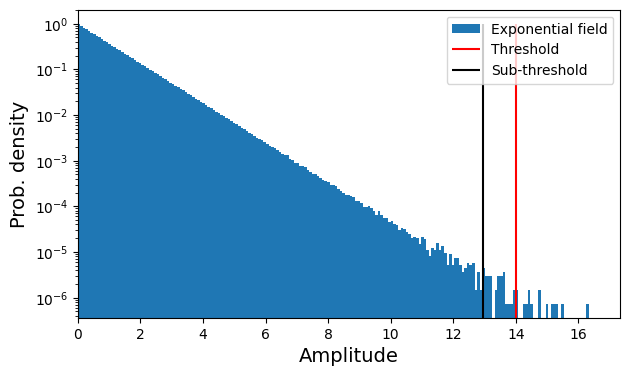

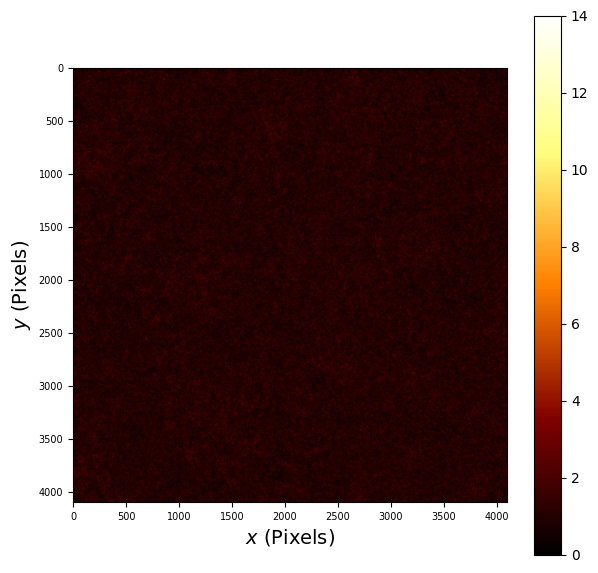

In [135]:
# @title Preliminary visualization

# Histogram of the exponential random field

plt.figure( figsize = (7,4))
plt.hist(exprf.flatten(), bins=201, density=True, label='Exponential field');
plt.yscale('log')
plt.xlim(0,exprf.max()+1)
plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Prob. density', fontsize=14)
plt.vlines(threshold, 0,1, color='r', label='Threshold')
plt.vlines(sub_threshold, 0,1, color='k', label='Sub-threshold')
plt.legend()
plt.savefig('Prob_dens.pdf', bbox_inches='tight', dpi=300)
plt.show()

psize = 7

# An intuitive realization of the random field

plt.figure( figsize = (psize,psize))
plt.imshow(exprf, cmap='afmhot')
plt.xlabel(f'$x$ (Pixels)',fontsize=psize*2)
plt.ylabel(f'$y$ (Pixels)',fontsize=psize*2)
plt.xticks(fontsize=psize)
plt.yticks(fontsize=psize)
plt.colorbar()
plt.clim(0,threshold)
plt.savefig('Field.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [136]:
# @title Clustering analysis

eps = 100
min_samples = 2

# Return an array indicating the coordinates
# where exprf > threshold
pos = np.argwhere(exprf > threshold)
all_pos = np.argwhere(exprf > sub_threshold)
#sub_pos = np.argwhere((exprf > sub_threshold) & (exprf < threshold))

print("\n # of threshold exceeding events:", pos.shape)
# print("\n # of potential events to exceed threshold after merging:", sub_pos.shape)
print("\n # of all canidates:", all_pos.shape)

"""
WARNING: This code will cause error here when the numpy array pos
is empty. That means that the program is unable to find any
threshold exceeding events. This will be fixed  in the future when
incorperating the loops by the continue command.
"""

# Run clustering algorithm for hard threshold
hc_labels, hc_clt_pos_dict = DBSCAN_CLUSTERING(data = pos, eps = eps, min_samples = min_samples)
# Run clustering algorithm for soft threshold
sc_labels, sc_clt_pos_dict = DBSCAN_CLUSTERING(data = all_pos, eps = eps, min_samples = min_samples)

# # of clusters soft threshold
sc_num_clt = len(set(sc_labels))
# # of clusters hard threshold
hc_num_clt = len(set(hc_labels))
print("\n # of cluster incl. anomoly: ", f"Soft: {sc_num_clt}", f"Hard: {hc_num_clt}")

# Color scheme defined bby the total # of clusters
sc_cmap = cm.get_cmap('rainbow', sc_num_clt)
hc_cmap = cm.get_cmap('rainbow', hc_num_clt)


 # of threshold exceeding events: (15, 2)

 # of all canidates: (50, 2)

 Cluster they belong to:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1]

 Cluster they belong to:  [ 0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  2  1  2 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  3  3 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1]

 # of cluster incl. anomoly:  Soft: 5 Hard: 2


<ipython-input-136-8cbccba4b3ed>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sc_cmap = cm.get_cmap('rainbow', sc_num_clt)
<ipython-input-136-8cbccba4b3ed>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  hc_cmap = cm.get_cmap('rainbow', hc_num_clt)


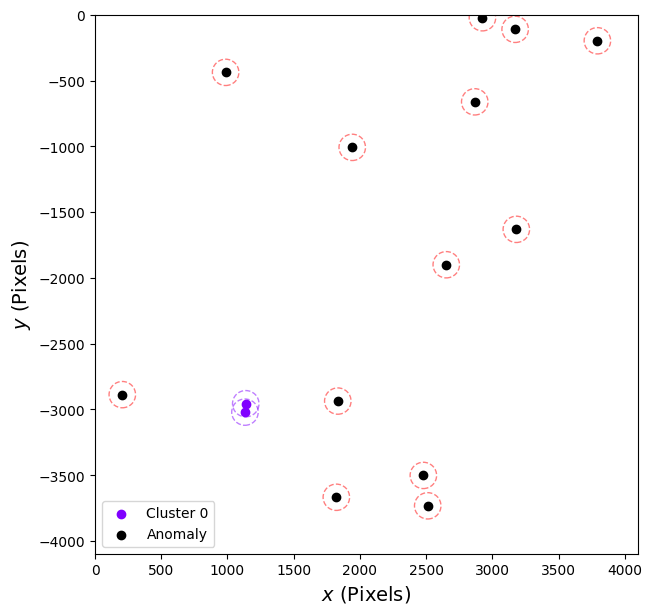

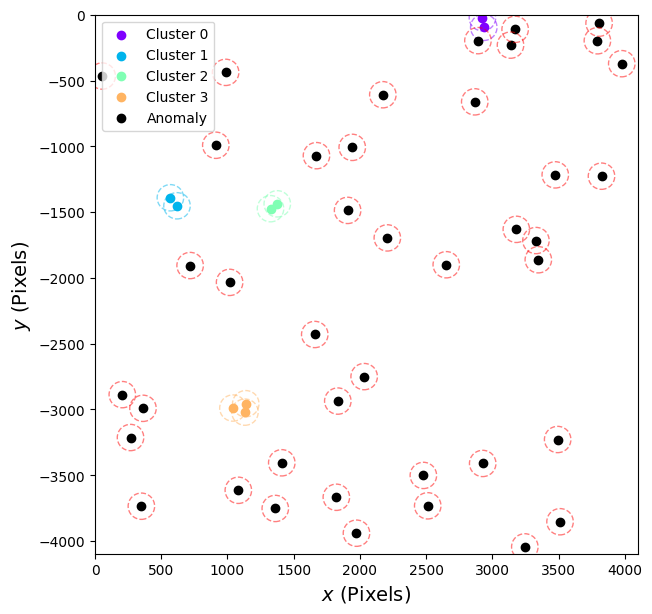

In [137]:
# @title Intuitive visualization of clustering

plt.figure( figsize = (psize,psize))

for ii in set(hc_labels):
    clt_idx = np.where(hc_labels == ii)
    clt_pos = pos[clt_idx]
    color = hc_cmap(ii % hc_num_clt)

    if ii == -1:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , c='k', label='Anomaly')
    else:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , color = color, label=f'Cluster {ii}')

    for p in clt_pos:
        circle = plt.Circle((p[1], -p[0]), eps, color = color, fill=False, linestyle='--', alpha=0.5)  # You can adjust the circle properties here
        plt.gca().add_artist(circle)


plt.xlabel(f'$x$ (Pixels)', fontsize=14)
plt.ylabel(f'$y$ (Pixels)', fontsize=14)
plt.xlim(0,exprf.shape[0])
plt.ylim(-exprf.shape[1],0)
plt.legend()
# plt.savefig('Cluster_Hard.pdf', bbox_inches='tight', dpi=300)
plt.show()


# @title Intuitive visualization of clustering

plt.figure( figsize = (psize,psize))

for ii in set(sc_labels):
    clt_idx = np.where(sc_labels == ii)
    clt_pos = all_pos[clt_idx]
    color = sc_cmap(ii % sc_num_clt)

    if ii == -1:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , c='k', label='Anomaly')
    else:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , color = color, label=f'Cluster {ii}')

    for p in clt_pos:
        circle = plt.Circle((p[1], -p[0]), eps, color = color, fill=False, linestyle='--', alpha=0.5)  # You can adjust the circle properties here
        plt.gca().add_artist(circle)


plt.xlabel(f'$x$ (Pixels)', fontsize=14)
plt.ylabel(f'$y$ (Pixels) ', fontsize=14)
plt.xlim(0,exprf.shape[0])
plt.ylim(-exprf.shape[1],0)
plt.legend()
# plt.savefig('Cluster_Soft.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [138]:
# Search for primary neighborhood
hc_coordinates_nn = find_nearest_neighbours(half_length = 1, labels = hc_labels, clt_pos_dict = hc_clt_pos_dict)
sc_coordinates_nn = find_nearest_neighbours(half_length = 1, labels = sc_labels, clt_pos_dict = sc_clt_pos_dict)

# Merge the primary and secondary neighborhoods # Note that "threshold" must always be the one defining the rare event.
hc_coordinates_nn, hc_clt_pos_dict_merged = merge_nearest_neighbour(exprf = exprf, labels = hc_labels, clt_pos_dict = hc_clt_pos_dict, coordinates_nn = hc_coordinates_nn)
sc_coordinates_nn, sc_clt_pos_dict_merged = merge_nearest_neighbour(exprf = exprf, labels = sc_labels, clt_pos_dict = sc_clt_pos_dict, coordinates_nn = sc_coordinates_nn)


Set of threshold exceedence : {(2956, 1138), (3020, 1132)}
Threshold exceedence coordinate: [3020 1132]
# of neighbours : 8
Set of intersection: set()
New set of threshold exceedence : {(2956, 1138)}
Threshold exceedence coordinate: [2956 1138]
# of neighbours : 8
Set of intersection: set()
New set of threshold exceedence : set()
# of Finial neighbourhood =  {'[2956 1138]': array([[2955, 1137],
       [2955, 1138],
       [2955, 1139],
       [2956, 1137],
       [2956, 1139],
       [2957, 1137],
       [2957, 1138],
       [2957, 1139]]), '[3020 1132]': array([[3019, 1131],
       [3019, 1132],
       [3019, 1133],
       [3020, 1131],
       [3020, 1133],
       [3021, 1131],
       [3021, 1132],
       [3021, 1133]])} 

Set of threshold exceedence : {(23, 2925), (96, 2935)}
Threshold exceedence coordinate: [  23 2925]
# of neighbours : 8
Set of intersection: set()
New set of threshold exceedence : {(96, 2935)}
Threshold exceedence coordinate: [  96 2935]
# of neighbours : 8
Set of 

In [139]:
hc_cluster_mass_i , hc_cluster_mass_ij = mass_conversion(exprf = exprf, labels = hc_labels, threshold = threshold, clt_pos_dict_merged = hc_clt_pos_dict_merged, coordinates_nn = hc_coordinates_nn)
sc_cluster_mass_i , sc_cluster_mass_ij = mass_conversion(exprf = exprf, labels = sc_labels, threshold = threshold, clt_pos_dict_merged = sc_clt_pos_dict_merged, coordinates_nn = sc_coordinates_nn)

hc_bare_mass_i, hc_bare_mass_ij = bare_mass_conversion(exprf = exprf, labels = hc_labels, threshold = threshold, clt_pos_dict = hc_clt_pos_dict)
sc_bare_mass_i, sc_bare_mass_ij = bare_mass_conversion(exprf = exprf, labels = sc_labels, threshold = threshold, clt_pos_dict = sc_clt_pos_dict)

[3020 1132] 14.5 (8,)
[2956 1138] 14.3 (8,)
Cluster0: total mass list [4.0610354641332576, 3.2960308525201665]
Cluster0: total mass 7.357066316653424
[  23 2925] 14.5 (8,)
[  96 2935] 13.5 (8,)
Cluster0: total mass list [3.5520688682117143, 0.0]
Cluster0: total mass 3.5520688682117143
[1391  569] 13.2 (8,)
[1452  619] 13.0 (8,)
Cluster1: total mass list [0.0, 0.0]
Cluster1: total mass 0.0
[1474 1325] 13.8 (8,)
[1437 1376] 13.1 (8,)
Cluster2: total mass list [0.0, 0.0]
Cluster2: total mass 0.0
[3020 1132] 14.5 (8,)
[2956 1138] 14.3 (8,)
[2989 1041] 13.2 (8,)
Cluster3: total mass list [4.0610354641332576, 3.2960308525201665, 0.0]
Cluster3: total mass 7.357066316653424
[2956 1138] 14.3
[3020 1132] 14.5
Cluster0: bare mass list [3.216426399796853, 3.4174688375909437]
Cluster0: bare_mass 6.633895237387797
[  23 2925] 14.5
[  96 2935] 13.5
Cluster0: bare mass list [3.369440249272257, 0.0]
Cluster0: bare_mass 3.369440249272257
[1391  569] 13.2
[1452  619] 13.0
Cluster1: bare mass list [0.0, 0

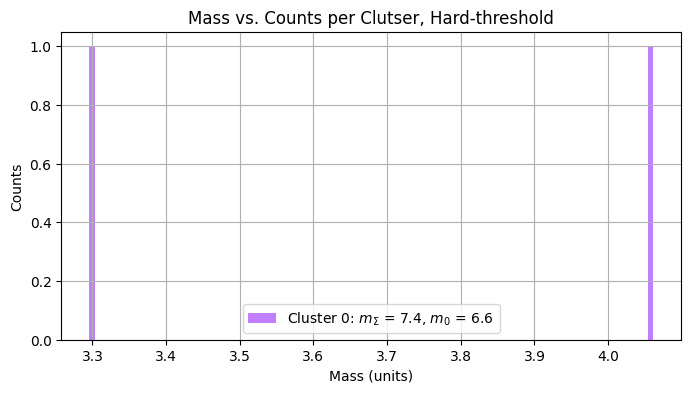

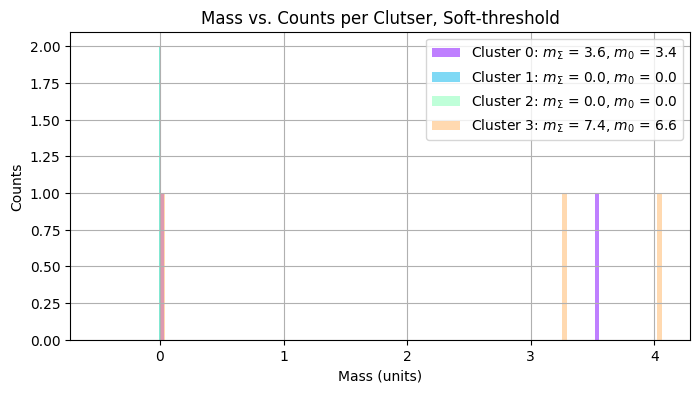

In [140]:
plt.figure( figsize = (8,4))

for ii in set(hc_labels)-{-1}:
    color = hc_cmap(ii % hc_num_clt)
    plt.hist(hc_cluster_mass_ij[ii][:], bins=101, label=f'Cluster {ii}: $m_\Sigma$ = {np.round(hc_cluster_mass_i[ii],1)}, $m_0$ = {np.round(hc_bare_mass_i[ii],1)}' , alpha =0.5, color=color)

plt.legend()
plt.title("Mass vs. Counts per Clutser, Hard-threshold")
plt.xlabel("Mass (units)")
plt.ylabel("Counts")
plt.grid()
plt.savefig('Mass_Hard.pdf', bbox_inches='tight', dpi=300)
plt.show()

plt.figure( figsize = (8,4))
for ii in set(sc_labels) -{-1}:
    color = sc_cmap(ii % sc_num_clt)
    plt.hist(sc_cluster_mass_ij[ii][:], bins=101, label=f'Cluster {ii}: $m_\Sigma$ = {np.round(sc_cluster_mass_i[ii],1)}, $m_0$ = {np.round(sc_bare_mass_i[ii],1)}' , alpha =0.5, color=color)

plt.legend()
plt.title("Mass vs. Counts per Clutser, Soft-threshold")
plt.xlabel("Mass (units)")
plt.ylabel("Counts")
plt.grid()
plt.savefig('Mass_Soft.pdf', bbox_inches='tight', dpi=300)
plt.show()

# plt.figure( figsize = (8,4))
# for ii in set(hc_labels)-{-1}:
#     color = cmap(ii % hc_num_clt)
#     plt.hist(bare_mass_list_ij[ii][:], bins=60,  label=f'Cluster {ii}', alpha =0.5, color=color)
# plt.title("Bare Mass vs. Counts per Clutser")
# plt.xlabel("Mass (units)")
# plt.ylabel("Counts")
# plt.grid()
# plt.legend()
# plt.show()

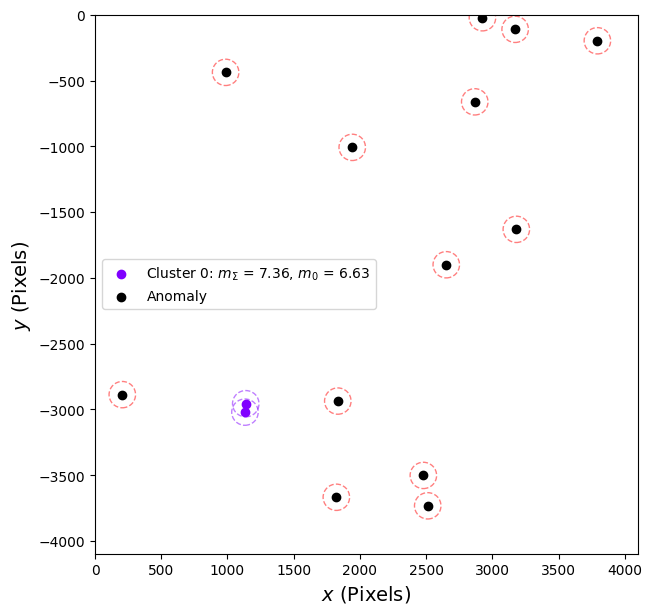

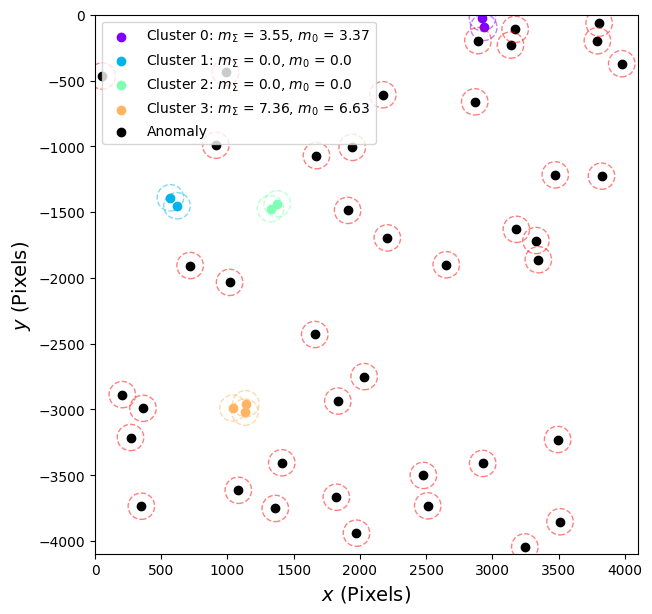

In [141]:
plt.figure( figsize = (7,7))

for ii in set(hc_labels):
    clt_idx = np.where(hc_labels == ii)
    clt_pos = pos[clt_idx]
    color = hc_cmap(ii % hc_num_clt)

    if ii == -1:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , c='k', label='Anomaly')
    else:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , color = color, label=f'Cluster {ii}: $m_\Sigma$ = {np.round(hc_cluster_mass_i[ii],2)}, $m_0$ = {np.round(hc_bare_mass_i[ii],2)}' )

    for p in clt_pos:
        circle = plt.Circle((p[1], -p[0]), eps, color = color, fill=False, linestyle='--', alpha=0.5)  # You can adjust the circle properties here
        plt.gca().add_artist(circle)

plt.xlabel(f'$x$ (Pixels)', fontsize=14)
plt.ylabel(f'$y$ (Pixels) ', fontsize=14)
plt.xlim(0,exprf.shape[0])
plt.ylim(-exprf.shape[1],0)
plt.legend()
plt.savefig('Cluster_Hard.pdf', bbox_inches='tight', dpi=300)
plt.show()

plt.figure( figsize=(7,7))

for ii in set(sc_labels):
    clt_idx = np.where(sc_labels == ii)
    clt_pos = all_pos[clt_idx]
    color = sc_cmap(ii % sc_num_clt)

    if ii == -1:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , c='k', label='Anomaly')
    else:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , color = color, label=f'Cluster {ii}: $m_\Sigma$ = {np.round(sc_cluster_mass_i[ii],2)}, $m_0$ = {np.round(sc_bare_mass_i[ii],2)}' )

    for p in clt_pos:
        circle = plt.Circle((p[1], -p[0]), eps, color = color, fill=False, linestyle='--', alpha=0.5)  # You can adjust the circle properties here
        plt.gca().add_artist(circle)

plt.xlabel(f'$x$ (Pixels)', fontsize=14)
plt.ylabel(f'$y$ (Pixels) ', fontsize=14)
plt.xlim(0,exprf.shape[0])
plt.ylim(-exprf.shape[1],0)
plt.legend()
plt.savefig('Cluster_Soft.pdf', bbox_inches='tight', dpi=300)
plt.show()